# BALANCING THE DATA

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the data
df = pd.read_csv('../data/cvss_data.csv', encoding='utf-8')
new_df = df[['english_description', 'cvssv3_scope']]

# Prepare the data for SMOTE
# Convert text data to numerical using TF-IDF
vectorizer = TfidfVectorizer(max_features=1000)  # Limit features to 1000 most frequent terms
X = vectorizer.fit_transform(new_df['english_description'].astype(str))

# Encode target variable
le = LabelEncoder()
y = le.fit_transform(new_df['cvssv3_scope'])

# Apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Convert y_balanced back to original labels
y_balanced = le.inverse_transform(y_balanced)

# Convert X_balanced back to text descriptions using inverse_transform
# Since we can't directly convert TF-IDF back to text, we'll use nearest neighbors
from sklearn.neighbors import NearestNeighbors

# Find nearest neighbors for each synthetic point
nbrs = NearestNeighbors(n_neighbors=1, n_jobs=-1).fit(X)
indices = nbrs.kneighbors(X_balanced, return_distance=False)

# Get the corresponding descriptions
balanced_descriptions = new_df['english_description'].iloc[indices.ravel()].values

# Create balanced dataframe
balanced_df = pd.DataFrame({
    'english_description': balanced_descriptions,
    'cvssv3_scope': y_balanced
})

# Export the balanced dataframe to a CSV file
output_file = 'balanced_cvss_data.csv'
balanced_df.to_csv(output_file, index=False)

# Show sample of the balanced data
print("Sample of balanced dataframe:")
print(balanced_df.head())
print("\
Shape of balanced dataframe:", balanced_df.shape)
print("\
Distribution of attack vectors in balanced data:")
print(balanced_df['cvssv3_scope'].value_counts())

Sample of balanced dataframe:
                                 english_description cvssv3_scope
0  "Non-transparent sharing of branch predictor s...      CHANGED
1  "Non-transparent sharing of branch predictor w...      CHANGED
2  "Hardware debug modes and processor INIT setti...    UNCHANGED
3  "Sensitive information accessible by physical ...    UNCHANGED
4  "Insertion of Sensitive Information into Log F...    UNCHANGED
Shape of balanced dataframe: (96668, 2)
Distribution of attack vectors in balanced data:
cvssv3_scope
CHANGED      48334
UNCHANGED    48334
Name: count, dtype: int64


C:\Users\O.Midiyanto\AppData\Local\Temp\ipykernel_1464\2160227934.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=original_df, x='cvssv3_scope', ax=ax1, palette='viridis')
C:\Users\O.Midiyanto\AppData\Local\Temp\ipykernel_1464\2160227934.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_df, x='cvssv3_scope', ax=ax2, palette='viridis')


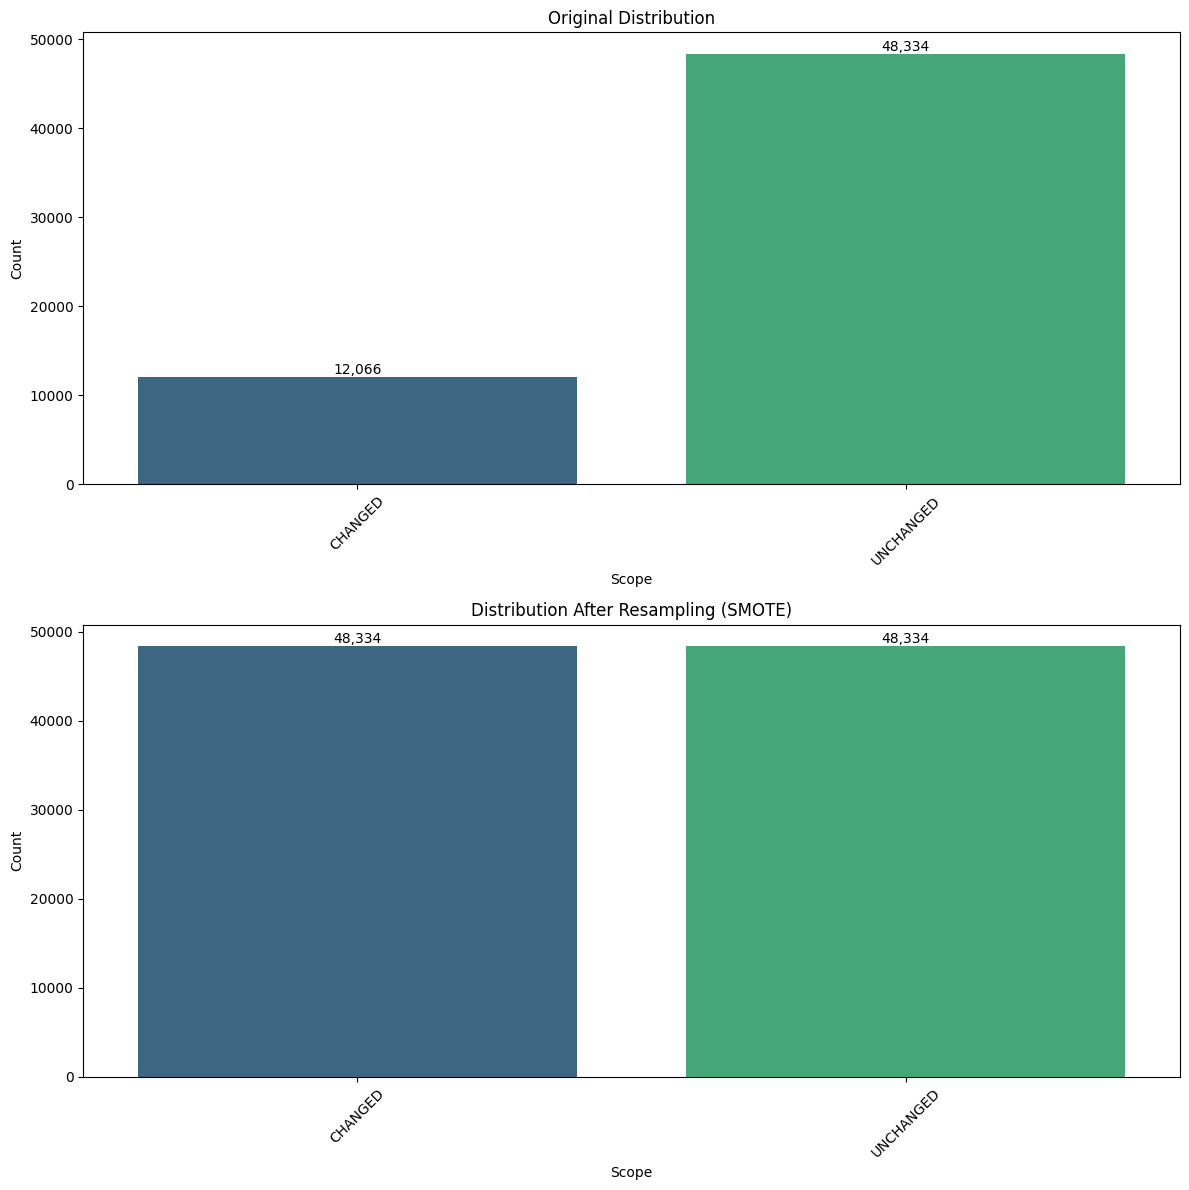

Original Distribution:
cvssv3_scope
UNCHANGED    48334
CHANGED      12066
Name: count, dtype: int64

Balanced Distribution:
cvssv3_scope
CHANGED      48334
UNCHANGED    48334
Name: count, dtype: int64


In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read original data
original_df = pd.read_csv('../data/cvss_data.csv')
original_df = original_df[['cvssv3_scope']]

# Read balanced data
balanced_df = pd.read_csv('./balanced_cvss_data.csv')

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot original distribution
sns.countplot(data=original_df, x='cvssv3_scope', ax=ax1, palette='viridis')
ax1.set_title('Original Distribution')
ax1.set_xlabel('Scope')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars for original data
for p in ax1.patches:
    ax1.annotate(format(int(p.get_height()), ','),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center',
                 va='bottom')

# Plot balanced distribution
sns.countplot(data=balanced_df, x='cvssv3_scope', ax=ax2, palette='viridis')
ax2.set_title('Distribution After Resampling (SMOTE)')
ax2.set_xlabel('Scope')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars for balanced data
for p in ax2.patches:
    ax2.annotate(format(int(p.get_height()), ','),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center',
                 va='bottom')

plt.tight_layout()
plt.show()

# Print the exact counts for original and balanced data
print("Original Distribution:")
print(original_df['cvssv3_scope'].value_counts())

print("\nBalanced Distribution:")
print(balanced_df['cvssv3_scope'].value_counts())

# GENERATE TRAIN AND TEST DATASET

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv('./balanced_cvss_data.csv')

print(data.shape)
data.info()

(96668, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96668 entries, 0 to 96667
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   english_description  96668 non-null  object
 1   cvssv3_scope         96668 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [4]:
for col_name in list(data.columns.values[0:9]):
    print(col_name)
    print( data[col_name].value_counts(dropna=False) )
    print("")

english_description
english_description
"Cross-site Scripting (XSS) - Stored in GitHub repository nilsteampassnet/teampass prior to 3.0.7."                                                                                                                                                                                                                                                                                                                                                                                              430
"Adobe Experience Manager versions 6.5.20 and earlier are affected by a stored Cross-Site Scripting (XSS) vulnerability that could be abused by an attacker to inject malicious scripts into vulnerable form fields. Malicious JavaScript may be executed in a victim’s browser when they browse to the page containing the vulnerable field."                                                                                                                                             

In [5]:
pd.set_option('display.max_colwidth', None)
print(data.loc[data['english_description'].str.split().apply(len) < 10]['english_description'].shape)
desc_len = data['english_description'].str.split().apply(len)


def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)

desc_len_sorted, samples = ecdf(desc_len)
print(np.percentile(desc_len_sorted, 2))
print("5%:", np.percentile(desc_len_sorted, 5), "10%:", np.percentile(desc_len_sorted, 10), "25%:", np.percentile(desc_len_sorted, 25),"50%:", np.percentile(desc_len_sorted, 50), " 75%:", np.percentile(desc_len_sorted, 75), " 90%:", np.percentile(desc_len_sorted, 90), " 95%:", np.percentile(desc_len_sorted, 95))

(2107,)
9.0
5%: 12.0 10%: 14.0 25%: 23.0 50%: 37.0  75%: 60.0  90%: 81.0  95%: 104.0


In [6]:
print("2%:", np.percentile(desc_len_sorted, 2))

from scipy import stats

print("percentile of 10: ", stats.percentileofscore(desc_len_sorted, 10))
print("percentile of 128: ", stats.percentileofscore(desc_len_sorted, 128))

2%: 9.0
percentile of 10:  2.5980676128605125
percentile of 128:  96.95245582819547


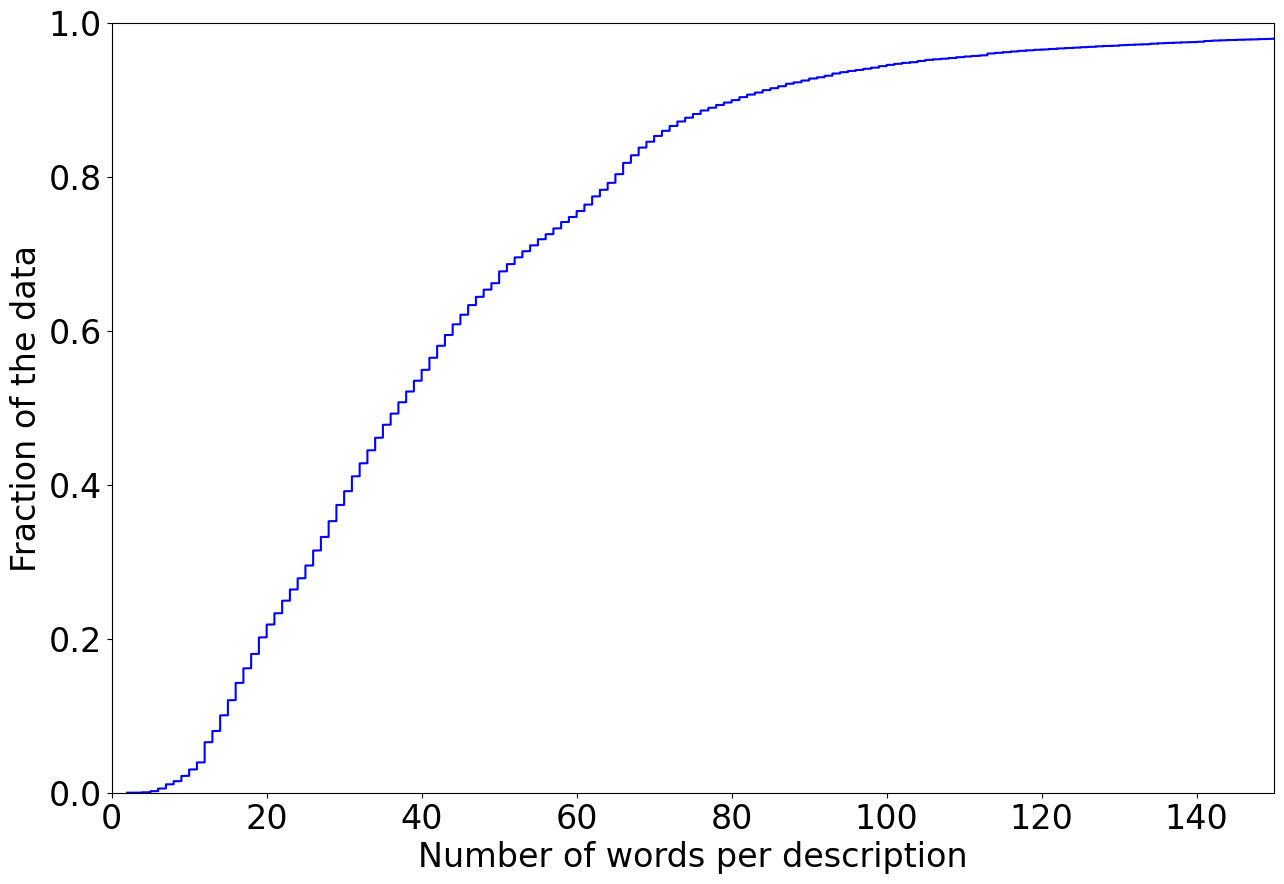

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
plt.plot(desc_len_sorted[:], samples[:], color='blue')
#plt.hlines(0.9, 0, 42, colors='r', linestyles='solid')
#plt.vlines(42, 0, 0.9, colors='r', linestyles='solid')
plt.axis([0, 150, 0, 1])
plt.xlabel('Number of words per description', fontsize=24)
plt.ylabel('Fraction of the data', fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=24)
#plt.savefig('', bbox_inches = 'tight')
plt.show()

In [8]:
pd.set_option('display.max_colwidth', None)

#discard samples with a "Description" field containing less than 10 words

#long_enough_description = data.loc[data['Description'].str.split().apply(len) >= 10]
#long_enough_description.reset_index(drop=True, inplace=True)
#long_enough_description.info()

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96668 entries, 0 to 96667
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   english_description  96668 non-null  object
 1   cvssv3_scope         96668 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


In [9]:
from sklearn.model_selection import train_test_split

X = data.iloc[:, [0]]
y = data.iloc[:, [1]]
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, shuffle=True)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(96668, 1)
(96668, 1)
(77334, 1)
(19334, 1)
(77334, 1)
(19334, 1)


In [10]:
X_train.to_csv('./cvss_2022_2024_X_train.csv', index=False)
y_train.to_csv('./cvss_2022_2024_y_train.csv', index=False)

X_test.to_csv('./cvss_2022_2024_X_test.csv', index=False)
y_test.to_csv('./cvss_2022_2024_y_test.csv', index=False)

In [11]:
import pandas as pd

X_train = pd.read_csv('./cvss_2022_2024_X_train.csv')
y_train = pd.read_csv('./cvss_2022_2024_y_train.csv')

X_test = pd.read_csv('./cvss_2022_2024_X_test.csv')
y_test = pd.read_csv('./cvss_2022_2024_y_test.csv')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(77334, 1)
(19334, 1)
(77334, 1)
(19334, 1)


In [12]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77334 entries, 0 to 77333
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cvssv3_scope  77334 non-null  object
dtypes: object(1)
memory usage: 604.3+ KB


In [13]:
for col_name in list(y_train.columns.values[0:8]):
    print("-----------------", col_name, "------------------------")
    print( y_train[col_name].value_counts(dropna=False) )
    print("")
    print( y_test[col_name].value_counts(dropna=False) )
    print("\n")

----------------- cvssv3_scope ------------------------
cvssv3_scope
CHANGED      38682
UNCHANGED    38652
Name: count, dtype: int64

cvssv3_scope
UNCHANGED    9682
CHANGED      9652
Name: count, dtype: int64




C:\Users\O.Midiyanto\AppData\Local\Temp\ipykernel_1464\4293635431.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_df_train, x='cvssv3_scope', ax=ax1, palette='viridis')
C:\Users\O.Midiyanto\AppData\Local\Temp\ipykernel_1464\4293635431.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=balanced_df_test, x='cvssv3_scope', ax=ax2, palette='viridis')


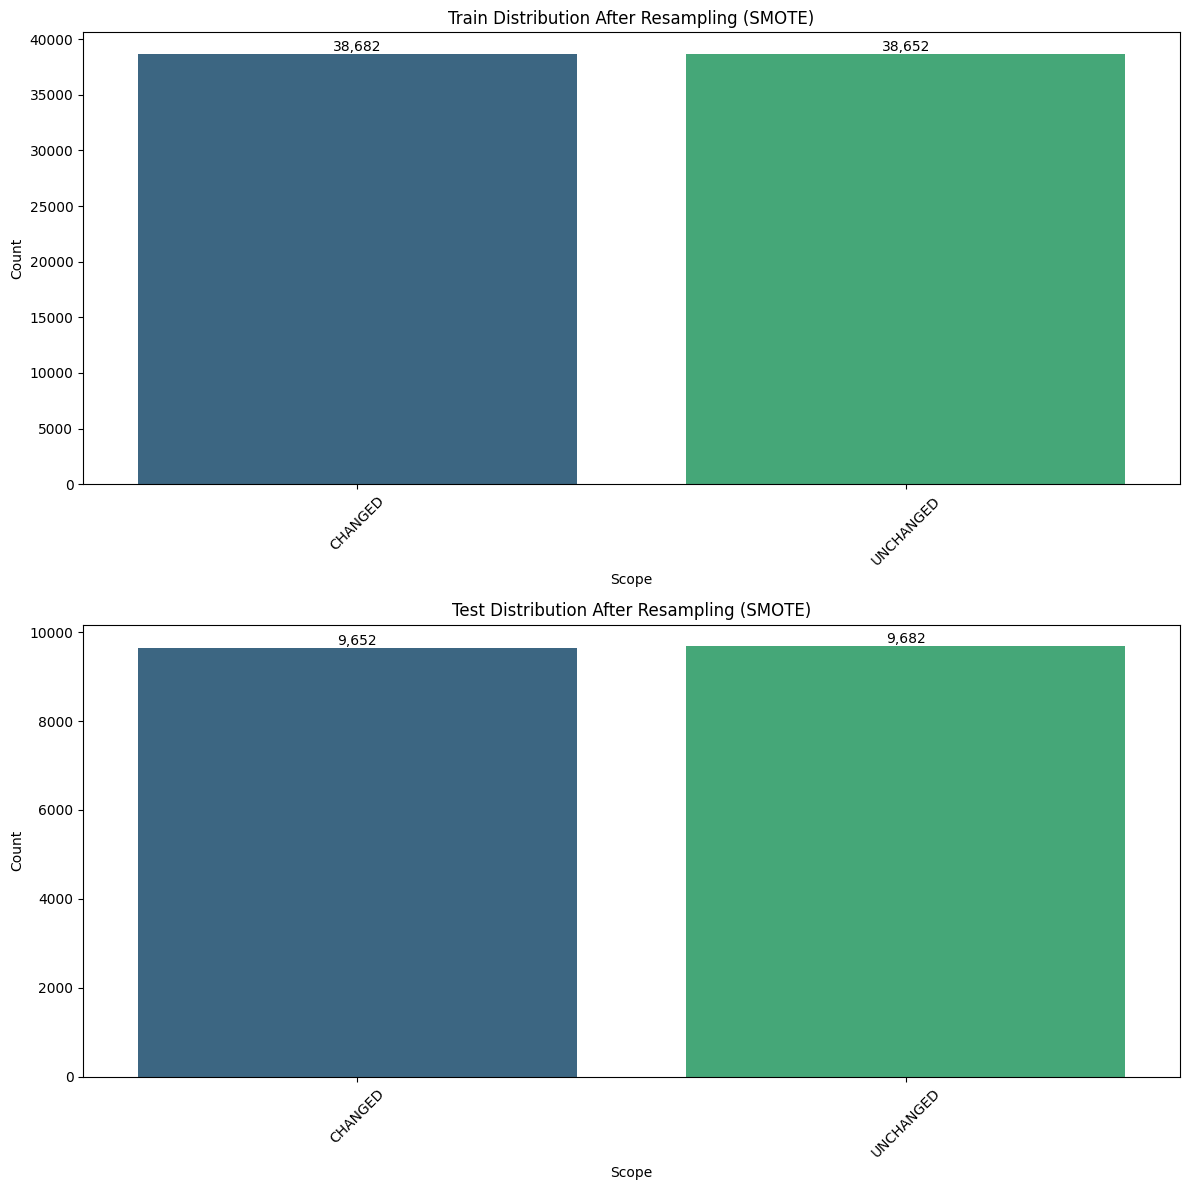

Train Distribution:
cvssv3_scope
CHANGED      38682
UNCHANGED    38652
Name: count, dtype: int64

Test Distribution:
cvssv3_scope
UNCHANGED    9682
CHANGED      9652
Name: count, dtype: int64


In [14]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read balanced data train and test
balanced_df_train = pd.read_csv('./cvss_2022_2024_y_train.csv')
balanced_df_test = pd.read_csv('./cvss_2022_2024_y_test.csv')

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# Plot train distribution
sns.countplot(data=balanced_df_train, x='cvssv3_scope', ax=ax1, palette='viridis')
ax1.set_title('Train Distribution After Resampling (SMOTE)')
ax1.set_xlabel('Scope')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=45)

# Add value labels on bars for train data
for p in ax1.patches:
    ax1.annotate(format(int(p.get_height()), ','),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center',
                 va='bottom')

# Plot test distribution
sns.countplot(data=balanced_df_test, x='cvssv3_scope', ax=ax2, palette='viridis')
ax2.set_title('Test Distribution After Resampling (SMOTE)')
ax2.set_xlabel('Scope')
ax2.set_ylabel('Count')
ax2.tick_params(axis='x', rotation=45)

# Add value labels on bars for test data
for p in ax2.patches:
    ax2.annotate(format(int(p.get_height()), ','),
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center',
                 va='bottom')

plt.tight_layout()
plt.show()

# Print the exact counts for train and test data
print("Train Distribution:")
print(balanced_df_train['cvssv3_scope'].value_counts())

print("\nTest Distribution:")
print(balanced_df_test['cvssv3_scope'].value_counts())


KESIMPULAN: DATA TELAH BALANCED, BAIK ITU TRAIN MAUPUN TEST